# Figure 3

## Imports

In [19]:
import os
import matplotlib.pyplot as plt
import numpy
import dolfin
import shutil

import dolfin_mech     as dmech

## Creating folder for temporary files

In [20]:
current_directory=os.getcwd()
new_directory="calc_fig3"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

In [21]:
alpha_lst=[0.016, 0.16, 1.6] ### values of alpha investigated

alpha = 0.16
gamma = 0.5
c1 = 0.6
c2 = 0. ## obsolete parameter
rho_solid =  1.06e-6


params = {
        "alpha": alpha,
        "gamma":gamma,
        "c1":c1,
        "c2":c2,
        "kappa":1e2,
        "eta":1e-5,
        "rho_solid":rho_solid}

mat_params = {"scaling":"linear", "parameters": params}

## Loading

In [22]:
pi_lst = numpy.linspace(0.5, 2, 21) ### range of end-inhalation pleural pressures studied

pe, pi = -0.5, -2. ### pleural pressure values 

gravity_lst = [0., 1.] ### 0 = without gravity, 1 = with gravity

## Mesh

In [23]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf"}


In [24]:
mesh = dolfin.Mesh()
mesh_name = str(cube_params["path_and_mesh_name"])
dolfin.XDMFFile(mesh_name).read(mesh)

## Computing Jacobian from end-exhalation to end-inhalation for different values of end-inhalation pleural pressures

In [25]:
results={}
for gravity_ in gravity_lst:
    for alpha_ in alpha_lst:
        mat_params["parameters"]["alpha"]=alpha_
        J_lst = []
        coef = -1. *gravity_
        load_params_inverse = {
            "type":"p_boundary_condition0", "f":coef*9.81e3, "P0" : float(pe)}
        load_params_direct_exhalation = {
            "type":"p_boundary_condition", "f":coef*9.81e3, "P0" : float(pe)}


        for pi_ in pi_lst:

            load_params_direct_inhalation= {
                "type":"p_boundary_condition", "f":coef*9.81e3, "P0" : -float(pi_)}
            

            
            U_exhal_to_unloaded, phis_unloaded, V_exhal, V_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
                    inverse=1,
                    dim=3,
                    mat_params=mat_params,
                    load_params=load_params_inverse,
                    res_basename = res_basename+"/inverse",
                    get_results=1,
                    inertia=1,
                    step_params={"dt_min":1e-4, "dt_ini":0.125},
                    cube_params=cube_params,
                    verbose=1)
            
            
            U_unloaded_to_inhal, phis_inhal, V_unloaded, V_inhal = dmech.run_RivlinCube_PoroHyperelasticity(
                inverse=0,
                dim=3,
                mat_params=mat_params,
                load_params=load_params_direct_inhalation,
                res_basename = res_basename+"/direct",
                get_results=1,
                inertia=1,
                step_params={"dt_min":1e-4}, 
                cube_params=cube_params,
                porosity_params= {"type": "function_xml_from_array", "val":phis_unloaded},
                move = {"move":True, "U":U_exhal_to_unloaded},
                verbose=1)
            
            V_exhal=dolfin.assemble(dolfin.Constant(1.)*V_exhal)
            V_inhal=dolfin.assemble(dolfin.Constant(1.)*V_inhal )
            
            J_def=V_inhal/V_exhal
            J_lst.append(J_def)
        results["J_alpha="+str(alpha_)+"g="+str(gravity_)]=J_lst
results["pi"]=pi_lst


In [26]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Generating plots

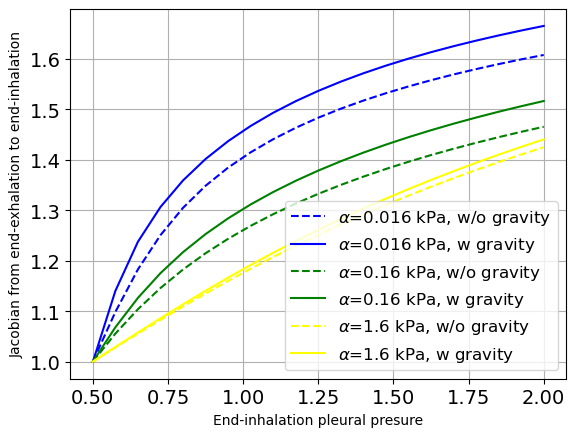

In [32]:
fig, ax = plt.subplots()

plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=12)

plt.xlabel("End-inhalation pleural presure"  , fontsize=10)
plt.ylabel("Jacobian from end-exhalation to end-inhalation", fontsize=10)

color_lst=['blue', 'green', 'yellow']
for alpha_ in alpha_lst:
    for gravity_ in gravity_lst:
        if gravity_:
            linestyle='-'
            g="w gravity"
        else:
            linestyle='--'
            g="w/o gravity"
        plt.plot(results["pi"], results["J_alpha="+str(alpha_)+"g="+str(gravity_)], color=color_lst[0], linestyle=linestyle, label=r'$\alpha$'+"="+str(alpha_)+" kPa, "+str(g))
    color_lst=color_lst[1:]

plt.legend()
plt.grid()

plt.show()